In [93]:
!pip install git+https://github.com/facebookresearch/esm.git -q

In [1]:
import numpy as np
import pandas as pd
import torch
# import esm
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm; tqdm.pandas()
import gc

In [2]:
!pip install -Uqq fastbook

In [3]:
from fastbook import *

In [4]:
df = pd.read_csv('df_combine.csv')
test_df = pd.read_csv('test_combine.csv')

## Seed

In [5]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

## Get esm feature

In [95]:
# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
    (1): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bia

In [96]:
if torch.cuda.is_available():
    model = model.cuda()
    print("Transferred model to GPU")

Transferred model to GPU


In [97]:
def get_feature(r,colname):
    data = [('protein',r[colname])]
    labels, strs, tokens = batch_converter(data)
    with torch.no_grad(): 
        results = model(tokens.cuda(), repr_layers=[33], return_contacts=True)
    rpr = results["representations"][33].squeeze()
    rpr=rpr[1 : len(r[colname]) + 1].mean(0).detach().cpu().numpy()
    
    del results, labels, strs, tokens, data #especially need to delete those on cuda: tokens, results

    return rpr

In [98]:
def get_feature_df(df,colname):
    series = df.progress_apply(lambda r: get_feature(r,colname), axis=1)
    df_feature = pd.DataFrame(series.tolist())
    return df_feature

### In order to process esm, delete long sequence

In [9]:
df['len'] = df.mut_seq.apply(len)

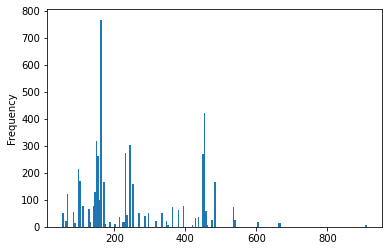

In [10]:
df.query('len < 1000').len.plot.hist(bins=200);

In [11]:
df = df.query('len < 800')

In [42]:
mut_feature = get_feature_df(df,'mut_seq')
wt_feature = get_feature_df(df,'wt_seq')

  0%|          | 0/5139 [00:00<?, ?it/s]

  0%|          | 0/5139 [00:00<?, ?it/s]

In [90]:
test = pd.read_csv('test_sub.csv')

In [99]:
test_mut = get_feature_df(test,'mut_seq')
test_wt = get_feature_df(test,'wt_seq')

  0%|          | 0/2413 [00:00<?, ?it/s]

  0%|          | 0/2413 [00:00<?, ?it/s]

In [101]:
test_combine.mut_seq.transform(len)

0       221
1       221
2       220
3       221
4       221
       ... 
2408    221
2409    221
2410    221
2411    221
2412    221
Name: mut_seq, Length: 2413, dtype: int64

In [110]:
test_feature = test_wt - test_mut
test_combine = pd.concat([test, test_feature],axis=1)
test_combine['len'] = test_combine.mut_seq.transform(len)
test_combine.to_csv('test_combine.csv')

In [113]:
test_combine.rename(columns={'pH':'pH2'},inplace=True)

In [146]:
test_df=test_combine.copy()

In [157]:
test_df.to_csv('test_combine.csv',index=False)

In [1]:
test_df = pd.read_csv('test_combine.csv')

NameError: name 'pd' is not defined

### Get feature differences

In [43]:
diff_feature = wt_feature - mut_feature

In [54]:
df.reset_index(inplace=True) #make sure the index of two concat dfs are same
df_combine = pd.concat([df, diff_feature], axis=1)

In [5]:
df_combine = pd.read_csv('with_esm_feature.csv')

## Filter out data with dTm

In [6]:
df_combine = df_combine.dropna(subset = 'Tm')

## Fill pH NaN

In [53]:
pd.options.mode.chained_assignment = None

In [8]:
df_combine['pH2'] = df_combine.groupby('group').pH.transform(lambda x: x.fillna(x.mean()))

### for those groups that don't have pH or pH.mean() at all, fill with 8

In [9]:
df_combine.pH2.fillna(8, inplace=True)

In [10]:
df_combine.pH2.isna().sum()

0

## Normalize Targets

In [11]:
df_combine['y_max'] = df_combine.groupby('group').Tm.transform(lambda x: x/x.max())

In [12]:
df_combine['y_normalize'] = df_combine.groupby('group').Tm.transform(lambda x: (x-x.mean())/x.std() )

In [13]:
df_combine.y_max.isna().sum(),df_combine.y_normalize.isna().sum()

(0, 52)

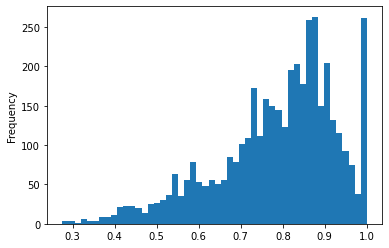

In [16]:
df_combine.y_max.plot.hist(bins=50);

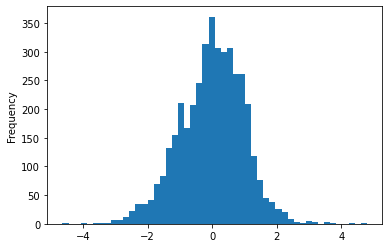

In [17]:
df_combine.y_normalize.plot.hist(bins=50);

### Interestingly, there are some groups with same Tm all the time (std=0), so filter out

In [18]:
df_combine[df_combine.groupby('group').Tm.transform(lambda x: x.std()==0)].group.unique()

array([37, 66, 68, 69])

In [19]:
df_combine[df_combine.y_normalize.isna()].group.unique()

array([37, 66, 68, 69])

In [20]:
df_combine = df_combine.dropna(subset='y_normalize')

In [21]:
37 in df_combine.group.to_list()

False

In [22]:
df_combine.shape

(4108, 1292)

In [116]:
df = df[df.group!=33]

## Check how many per group; remove group count < 20

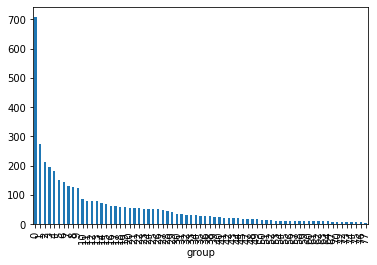

In [23]:
df_combine.groupby('group').mut_seq.count().plot.bar();

In [24]:
df_combine = df_combine[df_combine.groupby('group').mut_seq.transform(lambda x: x.count()>=20)]

### check the distribution of y_normalize after filter

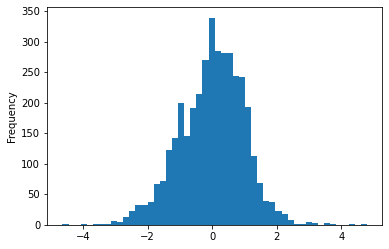

In [25]:
df_combine.y_normalize.plot.hist(bins=50);

### Redefine group number using ngroup

In [171]:
df['group'] = df.groupby(['group']).ngroup()

In [117]:
df.reset_index(drop=True, inplace=True)

In [118]:
df.to_csv('df_combine.csv', index=False)

In [119]:
df = pd.read_csv('df_combine.csv')


## Get groups with constant pH

In [20]:
df.groupby(['group','pH2']).mut_seq.count()

group  pH2 
0      1.99    False
       2.00     True
       2.02    False
       2.03    False
       2.10    False
               ...  
36     8.00    False
37     7.00     True
38     6.00     True
39     6.00    False
       7.00    False
Name: mut_seq, Length: 246, dtype: bool

In [54]:
df['group_pH'] = df.groupby(['group','pH2']).ngroup()

In [60]:
df.group_pH.sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41])

### remove groups with count <20

<AxesSubplot:ylabel='Frequency'>

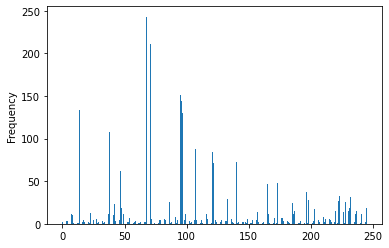

In [30]:
df.group_pH.plot.hist(bins=500);

<AxesSubplot:ylabel='Frequency'>

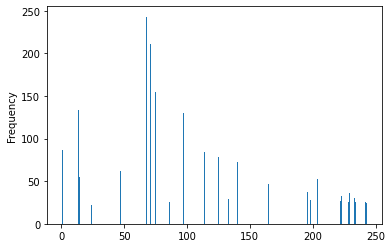

In [33]:
df[df.groupby('group_pH').mut_seq.transform(lambda x: x.count()>=20)].group_pH.plot.hist(bins=500)

In [34]:
df = df[df.groupby('group_pH').mut_seq.transform(lambda x: x.count()>=20)]

In [61]:
df.to_csv('df_combine2.csv',index=False)

## Define feature columns

In [37]:
esm_feature = [str(i) for i in range(1280)]

In [38]:
others = ['pH2','len']

In [39]:
features = esm_feature + others

## Make Dataset

In [40]:
from torch.utils.data import Dataset

In [62]:
class MyDataset(Dataset):
    def __init__(self,df, features,target,group,train=True):
        self.df = df
        self.features = features
        self.target = target
        self.train=train
        self.group=group
    def __len__(self): return len(self.df[self.group].unique())
    def __getitem__(self, idx): # add shuffle and random choice
        df_frac = self.df[self.df[self.group]==idx].sample(n=20) if self.train else self.df[self.df[self.group]==idx]#randomly pick 20
        
        feature = torch.as_tensor(df_frac.loc[:,self.features].values*1000,dtype=torch.float32)
        label = torch.as_tensor(df_frac.loc[:,self.target].values,dtype=torch.float32)
        return feature,label

In [63]:
dataset = MyDataset(df,features,'y_normalize','group_pH',train=True)

In [64]:
len(dataset)

42

In [69]:
x,y=dataset[41]

In [122]:
class TestDataset(Dataset):
    def __init__(self,df, features):
        self.df = df
        self.x = df.loc[:,features].values*1000
        # self.y = df.loc[:,target].values
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        feature = torch.as_tensor(self.x[idx],dtype=torch.float32)
        # label = torch.as_tensor(self.y[idx],dtype=torch.float32)
        return feature

In [133]:
x,y=dataset[0]

In [208]:
x.shape

torch.Size([20, 1282])

In [27]:
df[df.group==0].shape

(708, 1293)

### DataLoader

In [20]:
dl = DataLoader(dataset,bs=8,shuffle=True,num_workers=4)

In [21]:
x, y = dl.one_batch()

## Model

In [18]:
model1 = nn.Sequential(nn.LazyLinear(500),
                      nn.LazyBatchNorm1d(),
                      nn.LazyLinear(200),
                      nn.LazyBatchNorm1d(), 
                      nn.LazyLinear(1))

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [72]:
class Model2(Module):
    def __init__(self, num_features, num_targets, hidden_size):
        cha_1 = 256
        cha_2 = 512
        cha_3 = 512

        cha_1_reshape = int(hidden_size/cha_1)
        cha_po_1 = int(hidden_size/cha_1/2)
        cha_po_2 = int(hidden_size/cha_1/2/2) * cha_3

        self.cha_1 = cha_1
        self.cha_2 = cha_2
        self.cha_3 = cha_3
        self.cha_1_reshape = cha_1_reshape
        self.cha_po_1 = cha_po_1
        self.cha_po_2 = cha_po_2

        self.batch_norm1 = nn.BatchNorm1d(num_features)
        self.dropout1 = nn.Dropout(0.1)
        self.dense1 = nn.utils.weight_norm(nn.Linear(num_features, hidden_size))

        self.batch_norm_c1 = nn.BatchNorm1d(cha_1)
        self.dropout_c1 = nn.Dropout(0.1)
        self.conv1 = nn.utils.weight_norm(nn.Conv1d(cha_1,cha_2, kernel_size = 5, stride = 1, padding=2,  bias=False),dim=None)

        self.ave_po_c1 = nn.AdaptiveAvgPool1d(output_size = cha_po_1)

        self.batch_norm_c2 = nn.BatchNorm1d(cha_2)
        self.dropout_c2 = nn.Dropout(0.1)
        self.conv2 = nn.utils.weight_norm(nn.Conv1d(cha_2,cha_2, kernel_size = 3, stride = 1, padding=1, bias=True),dim=None)

        self.batch_norm_c2_1 = nn.BatchNorm1d(cha_2)
        self.dropout_c2_1 = nn.Dropout(0.3)
        self.conv2_1 = nn.utils.weight_norm(nn.Conv1d(cha_2,cha_2, kernel_size = 3, stride = 1, padding=1, bias=True),dim=None)

        self.batch_norm_c2_2 = nn.BatchNorm1d(cha_2)
        self.dropout_c2_2 = nn.Dropout(0.2)
        self.conv2_2 = nn.utils.weight_norm(nn.Conv1d(cha_2,cha_3, kernel_size = 5, stride = 1, padding=2, bias=True),dim=None)

        self.max_po_c2 = nn.MaxPool1d(kernel_size=4, stride=2, padding=1)

        self.flt = nn.Flatten()

        self.batch_norm3 = nn.BatchNorm1d(cha_po_2)
        self.dropout3 = nn.Dropout(0.2)
        self.dense3 = nn.utils.weight_norm(nn.Linear(cha_po_2, num_targets))

    def forward(self, x):

        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.celu(self.dense1(x), alpha=0.06)

        x = x.reshape(x.shape[0],self.cha_1,
                      self.cha_1_reshape)

        x = self.batch_norm_c1(x)
        x = self.dropout_c1(x)
        x = F.relu(self.conv1(x))

        x = self.ave_po_c1(x)

        x = self.batch_norm_c2(x)
        x = self.dropout_c2(x)
        x = F.relu(self.conv2(x))
        x_s = x

        x = self.batch_norm_c2_1(x)
        x = self.dropout_c2_1(x)
        x = F.relu(self.conv2_1(x))

        x = self.batch_norm_c2_2(x)
        x = self.dropout_c2_2(x)
        x = F.relu(self.conv2_2(x))
        x =  x * x_s

        x = self.max_po_c2(x)

        x = self.flt(x)

        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.dense3(x)

        return x

In [73]:
num_features = x.shape[1]
num_targets=1
hidden_size=4096

In [76]:
x = x.to(device)

In [78]:
model = Model2(num_features,num_targets,hidden_size)

In [79]:
model = model.to(device)

In [80]:
pred = model(x)

In [81]:
pred

tensor([[ 1.2487],
        [ 0.4335],
        [-0.3007],
        [ 0.2190],
        [-0.9422],
        [ 0.9492],
        [-0.4454],
        [-0.5357],
        [ 0.8943],
        [-0.5422],
        [ 0.0483],
        [ 0.2749],
        [ 1.5215],
        [-0.2835],
        [-1.4190],
        [-0.3366],
        [-0.6745],
        [-0.1032],
        [-0.3456],
        [-0.1123]], device='cuda:0', grad_fn=<AddmmBackward0>)

## Loss

In [82]:
!pip install torchsort

  Preparing metadata (setup.py) ... done
  Created wheel for torchsort: filename=torchsort-0.1.9-cp39-cp39-linux_x86_64.whl size=3037929 sha256=35e7018204e47ab66754a8ce5f68e624bcc352b3670564131231a6277f69ab3a
  Stored in directory: /root/.cache/pip/wheels/72/ec/75/5ef2081c0df220afc613a01260f3034f3f6a8f90f605c2b6ab
Successfully built torchsort


In [83]:
import torchsort

In [114]:
def spearman_loss(pred, target):

    x = 1e-3
    mse = MSELossFlat()(pred,target)
    pred = torchsort.soft_rank(pred.reshape(1,-1),regularization_strength=x)
    target = torchsort.soft_rank(target.reshape(1,-1),regularization_strength=x)
    pred = pred - pred.mean()
    pred = pred / pred.norm()
    target = target - target.mean()
    target = target / target.norm()
    ret = 1- (pred * target).sum()
    
    return mse + ret

In [117]:
def only_spearman_loss(pred, target):

    x = 1e-3
    # mse = MSELossFlat()(pred,target)
    pred = torchsort.soft_rank(pred.reshape(1,-1),regularization_strength=x)
    target = torchsort.soft_rank(target.reshape(1,-1),regularization_strength=x)
    pred = pred - pred.mean()
    pred = pred / pred.norm()
    target = target - target.mean()
    target = target / target.norm()
    ret = 1- (pred * target).sum()
    
    return ret

In [115]:
spearman_loss(pred,y)

TensorBase(1.3226, device='cuda:0')

## Prepare training

In [75]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [29]:
# learn = Learner(dl,model,loss_func=MSELossFlat())

In [ ]:
model = model2.cuda()

### Optimizer

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

### Scheduler

In [90]:
from torch.optim.lr_scheduler import OneCycleLR

In [ ]:
scheduler = OneCycleLR(optimizer, max_lr=1e-2,steps_per_epoch=len(dataset),div_factor=1e3, epochs=25,pct_start=0.1)

## Training OLOS

In [92]:
def train_fn(dataset,train_idx, model,loss_fn,optimizer,scheduler):
    
    model.train()
    final_loss=0

    for idx in train_idx:
        x,y=dataset[idx]
        x,y=x.to(device),y.to(device)

        pred=model(x)
        loss = loss_fn(pred,y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        final_loss +=loss.item()

    final_loss/=len(train_idx)

    return final_loss

In [ ]:
dataset = MyDataset(df,features,'y_normalize','group_pH',train=False)

In [108]:
valid_idx = [20,30]
model.eval()
final_loss = 0
spearmans = 0
preds = []
ys = []
with torch.no_grad():
    for idx in valid_idx:
        x, y = dataset[idx]
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)

        final_loss += loss.item()
        spearman = stats.spearmanr(pred.squeeze().cpu().numpy(), y.squeeze().cpu().numpy())
        # print(f'spearman loss for group {idx} is {spearman}')
        spearmans +=spearman.correlation
        preds.append(pred.detach().cpu().numpy())
        ys.append(y.detach().cpu().numpy())

final_loss /= len(valid_idx)
spearmans /= len(valid_idx)
ys,preds = np.concatenate(ys),np.concatenate(preds)

In [267]:
spearman.correlation

0.07503795589740603

In [264]:
stats.spearmanr(pred.,pred.squeeze().cpu().numpy())

SpearmanrResult(correlation=1.0, pvalue=0.0)

In [111]:
def valid_fn(dataset,valid_idx,model,loss_fn):

    model.eval()
    final_loss = 0
    spearmans = 0
    preds = []
    ys = []
    with torch.no_grad():
        for idx in valid_idx:
            x, y = dataset[idx]
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_fn(pred, y)

            final_loss += loss.item()
            spearman = stats.spearmanr(pred.squeeze().cpu().numpy(), y.squeeze().cpu().numpy())
            # print(f'spearman loss for group {idx} is {spearman}')
            spearmans +=spearman.correlation
            preds.append(pred.detach().cpu().numpy())
            ys.append(y.detach().cpu().numpy())

    final_loss /= len(valid_idx)
    spearmans /= len(valid_idx)
    ys,preds = np.concatenate(ys),np.concatenate(preds)
    
    return final_loss, preds,ys,spearmans

In [120]:
def test_fn(dl,model):
    model.eval()
    preds = []
    with torch.no_grad():
        for x in dl:
            x = x.to(device)
            pred = model(x)
            preds.append(pred.detach().cpu().numpy())
        
    preds = np.concatenate(preds)
    
    return preds

### GroupKFold

In [88]:
from sklearn.model_selection import KFold
from scipy import stats

In [96]:
!pip install -Uqq wandb

In [99]:
!wandb login

wandb: Currently logged in as: sky1ove. Use `wandb login --relogin` to force relogin


In [101]:
import wandb

In [118]:
EPOCHS=100
for fold, (train_idx, valid_idx) in enumerate(KFold(5,shuffle=True).split(df.group.unique())):
    print(f"-------Fold {fold}---------------")
    wandb.init(project="novoenzyme_only_spearmanLoss",name=f"fold_{fold}")
    
    train_ds = MyDataset(df,features,'y_normalize','group_pH',train=True)
    valid_ds = MyDataset(df,features,'y_normalize','group_pH',train=False)
    
    model = Model2(num_features,num_targets,hidden_size).cuda()
    loss_fn = only_spearman_loss
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = OneCycleLR(optimizer, max_lr=1e-2,steps_per_epoch=len(train_ds),div_factor=1e3, epochs=EPOCHS,pct_start=0.1)
    
    # oof = np.zeros((len(df), 1))
    best_spearman = 0
    
    for epoch in range(EPOCHS):
        train_loss = train_fn(train_ds,train_idx,model,loss_fn, optimizer,scheduler)
        valid_loss,valid_preds,valid_ys,spearmans = valid_fn(valid_ds,valid_idx, model,loss_fn)
        wandb.log({"train loss": train_loss, "valid loss": valid_loss, "spearman":spearmans})

        if spearmans > best_spearman:
            best_spearman = spearmans
            # oof[valid_idx] = valid_preds
            torch.save(model.state_dict(),f'my_model/fold{fold}.pth')

    wandb.finish()
    
    test_ds = TestDataset(test_df,features)
    test_dl = DataLoader(test_ds,bs=20,shuffle=False,num_workers=4)

    model = Model2(num_features,num_targets,hidden_size)
    model.load_state_dict(torch.load(f'my_model/fold{fold}.pth'))
    model.to(device)

    # oofs+=oof/2
    test_preds += test_fn(test_dl,model)/2

-------Fold 0---------------


-------Fold 1---------------


spearman,▅▅▄▅█▂▄▃▃▅▆▁▄▅▅▆▄▄▆▅▆▆▄▁██▆▆█▇████████▇▇
train loss,█▆▅▇▃▅▁▂▅▇▃▃▃▅▄▄▇▅▄▃▃▄▂█▅▄▄▃▅▃▂▁▂▃▁▂▁▁▄▃
valid loss,▃█▅▄▄▃▅▅▃▄▃▃▅█▁▁▃▃▁▂▁▁▁▁▁▁▁▁▂▂
spearman,0.15912
train loss,0.84342
valid loss,0.84088


-------Fold 2---------------


spearman,▆▅▁▄▂▃▂▇█▄█▁▄▄▄▃▄▄▅▅▆▇▅▅▄▅▆▆▆▆▆▆▆▅▅▅▅▅▆▇
train loss,▅▅▆▁▅██▃▂▅▄▅▅▃▂▅▆▅▆▅▅▃▅▃▁▃▄▁▂▃▆▄▅▂▃▃▃▄▄▃
valid loss,▁█▅▆▅▇▅▅▅▄▃▂▄▄▅▄▄▃▃▃▃▄▃▄▄▄▄▄▃▃
spearman,0.12865
train loss,0.88799
valid loss,0.87135


-------Fold 3---------------


spearman,▆▅▅▆▆▆▅▇▅▅▅▆▄▃▃▅▅▂▁▁▁▁▁▃▅▅▅▆▆█▄█▇▇▆▆▆▆▇▇
train loss,▅▃▁▁▁▂▇▅▆▂▂▂▅▆▆▄▄▅█▆▆▇▇▇▄▄▅▄▅▄▄▃▂▁▃▄▂▃▂▂
valid loss,▄▃▅▆▆▄▄▇█████▆▄▄▄▃▃▁▅▁▂▂▃▃▃▃▂▂
spearman,0.21086
train loss,0.8812
valid loss,0.78932


-------Fold 4---------------


spearman,▂▅▃▄▅▃▃▄▄▂▁▆▃▄▄▄▁█▇▇▇▅▄▄▁▁▁▃▅▂▅▄▃▃▃▃▃▂▃▂
train loss,▆▂▃▂▄▃▆▆█▄▆▄▅▆▆▆▅▄▃▂▁▃▂▃▃▄▃▂▄▃▂▃▄▃▃▅▅▄▅▇
valid loss,█▃▆▅▅▅█▁▂▂▂▄▅▅███▆▄▇▄▅▆▆▆▆▆▇▆▇
spearman,-0.02634
train loss,1.04261
valid loss,1.02623


spearman,▄▄▄▄▆▃▁▂▂▁▅▅▅▃▄▂▄▄▆▇█▇█▅▃▅▅▃▂▃▂▂▁▁▁▁▂▂▃▃
train loss,▆▂▄▃▄▅▆█▇█▇▆▄▆▇▇▄▃▄▆▃▄▁▃▄▆▄▄▇▅▅▆▆▆▅▆▄▅▅▅
valid loss,▇█▄▄▄▆▅▇▅▅▃▂▁▂▁▄▆▄▄▆▇▆▇▇████▇▇▆▆
spearman,-0.08207
train loss,0.93287
valid loss,1.08206


In [50]:
train_fn(train_dl,model,loss_fn, optimizer,scheduler)

0.8554554958647924

In [129]:
test_preds

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [138]:
def run_kfold(Nfolds=5, seed=0, EPOCHS=100,loss_fn=MSELossFlat()):
    seed_everything(seed)
    test_preds = np.zeros((len(test_df), 1))
    
    for fold, (train_idx, valid_idx) in enumerate(KFold(Nfolds,shuffle=True).split(df.group.unique())):
        print(f"-------Fold {fold}---------------")
        wandb.init(project="novoenzyme_MSELoss",name=f"seed{seed}_fold{fold}")

        train_ds = MyDataset(df,features,'y_normalize','group_pH',train=True)
        valid_ds = MyDataset(df,features,'y_normalize','group_pH',train=False)

        model = Model2(num_features,num_targets,hidden_size).cuda()
        # loss_fn = MSELossFlat()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
        scheduler = OneCycleLR(optimizer, max_lr=1e-2,steps_per_epoch=len(train_ds),div_factor=1e3, epochs=EPOCHS,pct_start=0.1)

        # oof = np.zeros((len(df), 1))
        best_spearman = 0

        for epoch in range(EPOCHS):
            train_loss = train_fn(train_ds,train_idx,model,loss_fn, optimizer,scheduler)
            valid_loss,valid_preds,valid_ys,spearmans = valid_fn(valid_ds,valid_idx, model,loss_fn)
            wandb.log({"train loss": train_loss, "valid loss": valid_loss, "spearman":spearmans})

            if spearmans > best_spearman:
                best_spearman = spearmans
                # oof[valid_idx] = valid_preds
                torch.save(model.state_dict(),f'my_model/fold{fold}.pth')
                print(f'fold{fold} saving model at epoch{epoch} when spearman is {best_spearman}')

        wandb.finish()

        test_ds = TestDataset(test_df,features)
        test_dl = DataLoader(test_ds,bs=20,shuffle=False,num_workers=4)

        model = Model2(num_features,num_targets,hidden_size)
        model.load_state_dict(torch.load(f'my_model/fold{fold}.pth'))
        model.to(device)

        # oofs+=oof/2
        test_preds += test_fn(test_dl,model)/Nfolds

    return test_preds
    

In [139]:
SEED = [0,1]

# oof = np.zeros((len(df), 1))
predictions = np.zeros((len(test_df), 1))

for seed in SEED:
    
    predict= run_kfold(seed=seed)
    predictions+=predict/len(SEED)
    # oof+=oof_/len(SEED)
    
# df['oof'] = oof
test_df['preds'] = predictions

-------Fold 0---------------


fold0 saving model when spearman is 0.12738196906781693
fold0 saving model when spearman is 0.2991361981447643
fold0 saving model when spearman is 0.37763960904194677
fold0 saving model when spearman is 0.4174345323526554
fold0 saving model when spearman is 0.4363874463675074
fold0 saving model when spearman is 0.4582810370244391
fold0 saving model when spearman is 0.48148205143999206
fold0 saving model when spearman is 0.48636402924488686
fold0 saving model when spearman is 0.4933084763701525
fold0 saving model when spearman is 0.5315828463564977
fold0 saving model when spearman is 0.5471742612870879


spearman,▃▃▃▁▃▅▄▆▆▆▇▆▇▇▇▇▇█▇▇▇▇▇▇▇▇▇█▇█▇███▇▇▇▇▇▇
train loss,▇█▅▄▃▂▂▂▃▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid loss,▁█▂▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
spearman,0.46712
train loss,0.43814
valid loss,0.91424


-------Fold 1---------------


fold1 saving model when spearman is 0.10192793697862022
fold1 saving model when spearman is 0.1084406194329781
fold1 saving model when spearman is 0.1582910795805306
fold1 saving model when spearman is 0.19329348727424772
fold1 saving model when spearman is 0.212035871745973
fold1 saving model when spearman is 0.29614667796683986
fold1 saving model when spearman is 0.3619391879410187
fold1 saving model when spearman is 0.3620346803754149
fold1 saving model when spearman is 0.377397471364805


spearman,▃▁▃▁▃▃▃▅█▇▇▇█▅▅▄▆▇▆▆▇▆▅▆▆▆▅▅▆▇▆▇▆▇▆▆▆▆▆▅
train loss,██▆▄▄▄▃▃▃▃▂▂▂▂▂▂▃▂▂▂▂▂▁▂▂▁▂▂▁▁▂▂▁▁▁▁▁▂▁▁
valid loss,▁██▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
spearman,0.21158
train loss,0.39323
valid loss,0.72557


-------Fold 2---------------


fold2 saving model when spearman is 0.08740147306007896
fold2 saving model when spearman is 0.12783567805418666
fold2 saving model when spearman is 0.1568714899824754
fold2 saving model when spearman is 0.2417613284512498
fold2 saving model when spearman is 0.27272922505876646
fold2 saving model when spearman is 0.29553605722394044


spearman,▁▄▁▄▅▅▆▆▆▇▆█▇▆█▆▇▆▅▇▇▇▆▆▆█▇▇▆█▆█▆▆▆▆▆▆▇▇
train loss,▇█▄▅▃▄▃▂▃▃▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▂▁▂▁▁▁▂
valid loss,▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
spearman,0.21946
train loss,0.43507
valid loss,0.79523


-------Fold 3---------------


fold3 saving model when spearman is 0.09103415913531299
fold3 saving model when spearman is 0.1095775057696705
fold3 saving model when spearman is 0.3266170128807259
fold3 saving model when spearman is 0.33666973364025615
fold3 saving model when spearman is 0.37151274916295723


spearman,▄▃▁▃▃▄▁▃▇▆▇█▇▇▇▇▇▇▇▆▇█▇▆▇▇██▇▇██▇▇▇█▆█▇▇
train loss,▇█▅▄▃▃▃▃▂▂▂▂▂▁▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁
valid loss,▁▁█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
spearman,0.2732
train loss,0.39631
valid loss,0.8611


-------Fold 4---------------


fold4 saving model when spearman is 0.01747873080287878
fold4 saving model when spearman is 0.11060210345877326
fold4 saving model when spearman is 0.1855316503622975
fold4 saving model when spearman is 0.19016239904241983
fold4 saving model when spearman is 0.19584101832781084
fold4 saving model when spearman is 0.36260207555458934
fold4 saving model when spearman is 0.3792575842075483
fold4 saving model when spearman is 0.38837314566623116


spearman,▃▁▃▄▂▅▂▅▇▇▆▇▇▅▆▆▅▆▇█▇▇▇▇▇█▇▇█▇█▇▇█▇▇▇█▇▇
train loss,███▆▄▄▃▃▃▂▃▂▂▂▂▂▂▂▂▃▂▂▂▂▂▂▁▁▂▂▂▂▁▁▁▁▁▁▁▂
valid loss,▁▁█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
spearman,0.3109
train loss,0.4193
valid loss,0.98898


-------Fold 0---------------


fold0 saving model when spearman is 0.13328582314558693
fold0 saving model when spearman is 0.15828110676834137
fold0 saving model when spearman is 0.24559103827471038
fold0 saving model when spearman is 0.2911479672808695
fold0 saving model when spearman is 0.3131323538319924
fold0 saving model when spearman is 0.3137738270154146
fold0 saving model when spearman is 0.3173966225843878


spearman,▅▄▄▄▃▄▃▆▁▅▅▅▆█▆██▇█▆▇▇▇▇▇▇█▇▇▇▇▇▇▇█▇▇▆▇▇
train loss,▇█▅▄▃▃▂▂▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▂▁▁
valid loss,▁█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
spearman,0.27356
train loss,0.44642
valid loss,0.68597


-------Fold 1---------------


fold1 saving model when spearman is 0.00021840192115881889
fold1 saving model when spearman is 0.08161963229198935
fold1 saving model when spearman is 0.2071427289932323
fold1 saving model when spearman is 0.23122421636078475
fold1 saving model when spearman is 0.2777722126218359
fold1 saving model when spearman is 0.36258738221507014
fold1 saving model when spearman is 0.3691523120018732
fold1 saving model when spearman is 0.4289322437729431
fold1 saving model when spearman is 0.4473981755845603
fold1 saving model when spearman is 0.4857915902723953
fold1 saving model when spearman is 0.4938448154046392


spearman,▃▂▃▃▁▄▄▆▇▆▇▇▇▇▇▇▇█▆█▇▇▇▇██▇▇█▇▇▇▇▇▇█▇▇▇▇
train loss,██▆▄▃▃▃▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁
valid loss,▁▁█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
spearman,0.39467
train loss,0.4094
valid loss,0.71691


-------Fold 2---------------


fold2 saving model when spearman is 0.054073585325082406
fold2 saving model when spearman is 0.08149592743043534
fold2 saving model when spearman is 0.11295173843624354
fold2 saving model when spearman is 0.13439464841508206
fold2 saving model when spearman is 0.25265380846413743
fold2 saving model when spearman is 0.26196259077818457
fold2 saving model when spearman is 0.3189440152324097
fold2 saving model when spearman is 0.32991190424035816
fold2 saving model when spearman is 0.36643994143744124


spearman,▂▁▂▃▂▆▅▇█▅▅▅▆█▆▆▆▇▇▆▅▆▆▅▅▅▅▄▅▄▅▅▅▅▆▆▅▆▄▆
train loss,▇█▆▄▄▃▂▃▂▃▃▂▂▂▂▂▁▁▂▂▁▁▂▂▂▂▁▁▁▂▁▂▁▁▂▁▁▁▁▁
valid loss,▁▁█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
spearman,0.24386
train loss,0.44937
valid loss,0.66574


-------Fold 3---------------


fold3 saving model when spearman is 0.11855599420798367
fold3 saving model when spearman is 0.21292380912114472
fold3 saving model when spearman is 0.35221962773543025
fold3 saving model when spearman is 0.3920834603877464
fold3 saving model when spearman is 0.394250349832284


spearman,▄▁▃▂▁▅▂▄█▇▅▆█▇▆▆▇▆▆▆▆▆▆▇▆▆▆▆▆▇▇▆▇▆▅▆▆▇▆▇
train loss,▇█▇▅▃▃▂▂▂▂▂▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▂▁▁▁▁▂▁▁▁▁
valid loss,▁▁█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
spearman,0.30223
train loss,0.38347
valid loss,1.01068


-------Fold 4---------------


fold4 saving model when spearman is 0.026803682579226062
fold4 saving model when spearman is 0.13770107957567299
fold4 saving model when spearman is 0.13849952973661192
fold4 saving model when spearman is 0.23219930190855176
fold4 saving model when spearman is 0.29663109635683615
fold4 saving model when spearman is 0.430198108988795
fold4 saving model when spearman is 0.46568781616892263
fold4 saving model when spearman is 0.47406357951874795
fold4 saving model when spearman is 0.4745566537192076
fold4 saving model when spearman is 0.4768900959706271
fold4 saving model when spearman is 0.49110030632389073
fold4 saving model when spearman is 0.49500958036118314
fold4 saving model when spearman is 0.5056962818566605
fold4 saving model when spearman is 0.5090154214152811


spearman,▂▃▂▂▁▁▅▄▄▄▄▆▇▇▇▇█▆▇█▇▇▇▇▇▇▆█▇▆▇█████████
train loss,██▅▄▃▃▂▃▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▁▂▁▁▂▂▁▁▂▁▂▁▁▁▁▁▁
valid loss,▁▄█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
spearman,0.49122
train loss,0.38719
valid loss,1.00592


In [140]:
test_df.head()

,seq_id,mut_seq,pH2,wt_seq,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,...,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035,1036,1037,1038,1039,1040,1041,1042,1043,1044,1045,1046,1047,1048,1049,1050,1051,1052,1053,1054,1055,1056,1057,1058,1059,1060,1061,1062,1063,1064,1065,1066,1067,1068,1069,1070,1071,1072,1073,1074,1075,1076,1077,1078,1079,1080,1081,1082,1083,1084,1085,1086,1087,1088,1089,1090,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100,1101,1102,1103,1104,1105,1106,1107,1108,1109,1110,1111,1112,1113,1114,1115,1116,1117,1118,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128,1129,1130,1131,1132,1133,1134,1135,1136,1137,1138,1139,1140,1141,1142,1143,1144,1145,1146,1147,1148,1149,1150,1151,1152,1153,1154,1155,1156,1157,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167,1168,1169,1170,1171,1172,1173,1174,1175,1176,1177,1178,1179,1180,1181,1182,1183,1184,1185,1186,1187,1188,1189,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200,1201,1202,1203,1204,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214,1215,1216,1217,1218,1219,1220,1221,1222,1223,1224,1225,1226,1227,1228,1229,1230,1231,1232,1233,1234,1235,1236,1237,1238,1239,1240,1241,1242,1243,1244,1245,1

In [143]:
cols=['seq_id','preds']

In [144]:
submission = test_df.loc[:,cols]

In [148]:
submission.rename(columns={"preds":"tm"},inplace=True)

In [149]:
submission.to_csv('sub.csv',index=False)

In [142]:
test_df.to_csv('predictions.csv',index=False)

## Check prediction score and plot

In [ ]:
stats.spearmanr(valid_preds, valid_ds.y)

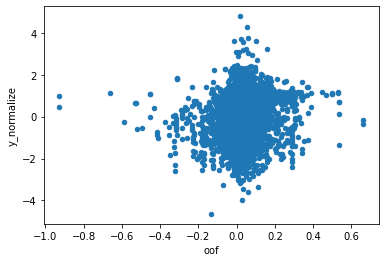

In [53]:
df.plot.scatter(x='oof',y='y_normalize');

### Check spearman score per group

In [54]:
df.groupby('group')[['oof','y_normalize']].apply(lambda x: x.corr('spearman').oof.y_normalize)

group
0     0.073685
1     0.271525
2     0.162579
3     0.310813
4     0.207076
5     0.178303
6     0.139770
7     0.224328
8     0.009251
9     0.251276
10    0.062934
11    0.315801
12    0.431585
13    0.388309
14    0.299967
15   -0.163214
16   -0.012990
17    0.170564
18    0.324426
19    0.571364
20    0.076772
21    0.313968
22    0.497625
23   -0.136987
24    0.295745
25    0.441062
26    0.107100
27    0.277696
28    0.507661
29    0.539755
30    0.321945
31   -0.148490
32    0.191930
34    0.177243
35    0.463575
36    0.007946
38    0.452398
39    0.173144
40    0.039131
41    0.273554
dtype: float64

In [77]:
df[['oof','y_normalize']].corr('spearman')

,oof,y_normalize
oof,1.000000,0.038054
y_normalize,0.038054,1.000000


In [162]:
test_preds

array([[0.47156996],
       [0.53584355],
       [0.5202725 ],
       ...,
       [0.5280656 ],
       [0.5192892 ],
       [0.6572173 ]], dtype=float32)

In [94]:
model.cuda()

Sequential(
  (0): Linear(in_features=1282, out_features=500, bias=True)
  (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=500, out_features=200, bias=True)
  (3): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Linear(in_features=200, out_features=1, bias=True)
)

In [95]:
for epoch in range(5):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(dl)
    test(dl)

Epoch 1
-------------------------------
loss: 1.080293  [    0/ 3764]
loss: 1.687482  [  800/ 3764]
loss: 1.118925  [ 1600/ 3764]
loss: 0.757889  [ 2400/ 3764]
loss: 0.668643  [ 3200/ 3764]
Test Error: Avg loss: 0.945010
Epoch 2
-------------------------------
loss: 0.988457  [    0/ 3764]
loss: 0.538472  [  800/ 3764]
loss: 1.003537  [ 1600/ 3764]
loss: 0.696454  [ 2400/ 3764]
loss: 0.936770  [ 3200/ 3764]
Test Error: Avg loss: 0.940664
Epoch 3
-------------------------------
loss: 0.864447  [    0/ 3764]
loss: 0.333849  [  800/ 3764]
loss: 0.419051  [ 1600/ 3764]
loss: 1.874793  [ 2400/ 3764]
loss: 0.546775  [ 3200/ 3764]
Test Error: Avg loss: 0.917771
Epoch 4
-------------------------------
loss: 0.171663  [    0/ 3764]
loss: 0.947445  [  800/ 3764]
loss: 1.595440  [ 1600/ 3764]
loss: 0.756516  [ 2400/ 3764]
loss: 0.356026  [ 3200/ 3764]
Test Error: Avg loss: 0.940091
Epoch 5
-------------------------------
loss: 1.478294  [    0/ 3764]
loss: 0.909177  [  800/ 3764]
loss: 0.459987  

In [57]:
df_combine.to_csv('with_esm_feature.csv', index=False)

In [57]:
gc.collect();torch.cuda.empty_cache()

# Get WT feature

In [89]:
df_wt = pd.DataFrame(df2.wildtype.unique())

In [94]:
df_wt.rename(columns={0: 'protein_sequence'},inplace=True)

In [95]:
wt_feature = get_feature_df(df_wt)

  0%|          | 0/78 [00:00<?, ?it/s]

In [99]:
wt_combine = pd.concat([df_wt, wt_feature], axis=1)

In [102]:
wt_combine.to_csv('wildtype_feature.csv', index=False)

# Get WT-mutant differences

In [112]:
wt_combine.head()

,protein_sequence,0,1,2,3,4,5,6,7,8,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,MPVRRGHVAPQNTFLDTIIRKFEGQSRKFIIANARVENCAVIYCND...,0.015805,-0.033919,0.005356,-0.001142,-0.037829,-0.062076,0.034698,0.074689,0.025458,...,0.031189,-0.033546,-0.103467,0.056230,-0.052916,-0.003619,-0.020674,-0.058185,0.027794,0.081028
1,MEELQDDYEDMMEENLEQEEYEDPDIPESQMEEPAAHDTEATATDY...,-0.017728,0.002291,-0.005282,-0.005080,-0.027136,-0.036133,0.065131,0.004717,0.007467,...,0.056245,0.033457,-0.124666,-0.020386,0.027567,-0.074638,0.048811,-0.047698,0.007801,0.049899
2,MTDITANVVVSNPRPIFTESRSFKAVANGKIYIGQIDTDPVNPANQ...,0.016938,0.050288,0.001779,-0.010340,-0.100914,0.016280,0.007097,-0.068371,0.050936,...,0.037742,-0.022452,0.080056,0.028671,0.020483,0.058210,0.075229,-0.084503,0.046309,0.086032
3,MSSRKELANAIRALSMDAVQKAKSGHPGAPMGMADIAEVLWRDFLK...,-0.011090,0.016666,-0.012930,0.030634,-0.012921,-0.012898,0.045492,-0.175886,0.034107,...,-0.067271,-0.067047,-0.062890,-0.037578,-0.029985,0.007193,0.019816,-0.198807,-0.022456,0.110925
4,MRPSLPPLLTCLLAALPALLSAGCSPATPSAHAAEPASRNVPFPYA...,-0.005208,-0.068409,0.039885,-0.062333,0.012764,-0.049863,0.015773,-0.156441,-0.020250,...,-0.021826,-0.072720,-0.002612,-0.078776,-0.078234,0.016206,0.081448,-0.206387,0.055972,0.011760


In [113]:
wt_combine.rename(columns={'protein_sequence': 'wildtype'},inplace=True)

In [117]:
all_enzymes_wildtype_feature = df_combine[['wildtype']].merge(wt_combine)

In [119]:
all_enzymes_wildtype_feature.to_csv('all_enzymes_wildtype_feature.csv', index=False)

# Get WT-mutant differences

In [ ]:
# wt = pd.read_csv('all_enzymes_wildtype_feature.csv')
# df_combine = pd.read_csv('all_enzymes_feature')

In [124]:
wt = all_enzymes_wildtype_feature.iloc[:,1:]

In [133]:
mutant = df_combine.iloc[:,-1280:]

In [134]:
wt

,0,1,2,3,4,5,6,7,8,9,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,0.015805,-0.033919,0.005356,-0.001142,-0.037829,-0.062076,0.034698,0.074689,0.025458,0.099601,...,0.031189,-0.033546,-0.103467,0.056230,-0.052916,-0.003619,-0.020674,-0.058185,0.027794,0.081028
1,0.015805,-0.033919,0.005356,-0.001142,-0.037829,-0.062076,0.034698,0.074689,0.025458,0.099601,...,0.031189,-0.033546,-0.103467,0.056230,-0.052916,-0.003619,-0.020674,-0.058185,0.027794,0.081028
2,0.015805,-0.033919,0.005356,-0.001142,-0.037829,-0.062076,0.034698,0.074689,0.025458,0.099601,...,0.031189,-0.033546,-0.103467,0.056230,-0.052916,-0.003619,-0.020674,-0.058185,0.027794,0.081028
3,0.015805,-0.033919,0.005356,-0.001142,-0.037829,-0.062076,0.034698,0.074689,0.025458,0.099601,...,0.031189,-0.033546,-0.103467,0.056230,-0.052916,-0.003619,-0.020674,-0.058185,0.027794,0.081028
4,0.015805,-0.033919,0.005356,-0.001142,-0.037829,-0.062076,0.034698,0.074689,0.025458,0.099601,...,0.031189,-0.033546,-0.103467,0.056230,-0.052916,-0.003619,-0.020674,-0.058185,0.027794,0.081028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6586,0.056222,-0.019059,0.034438,0.042787,-0.081775,0.047643,0.119286,-0.011242,-0.062220,-0.031445,...,0.063324,-0.103465,-0.039717,-0.029019,0.053409,-0.129892,0.118203,-0.196604,0.070822,0.114469
6587,0.056222,-0.019059,0.034438,0.042787,-0.081775,0.047643,0.119286,-0.011242,-0.062220,-0.031445,...,0.063324,-0.103465,-0.039717,-0.029019,0.053409,-0.129892,0.118203,-0.196604,0.070822,0.114469
6588,0.056222,-0.019059,0.034438,0.042787,-0.081775,0.047643,0.119286,-0.011242,-0.062220,-0.031445,...,0.063324,-0.103465,-0.039717,-0.029019,0.053409,-0.129892,0.118203,-0.196604,0.070822,0.114469
6589,0.056222,-0.019059,0.034438,0.042787,-0.081775,0.047643,0.119286,-0.011242,-0.062220,-0.031445,...,0.063324,-0.103465,-0.039717,-0.029019,0.053409,-0.129892,0.118203,-0.196604,0.070822,0.114469


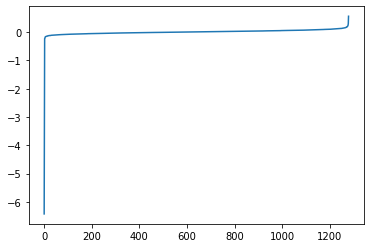

In [172]:
wt.iloc[1,:].sort_values().reset_index(drop=True).plot.line();

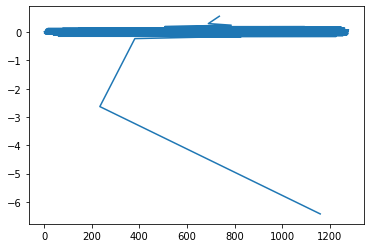

In [168]:
wt.iloc[1,:].sort_values().plot.line();

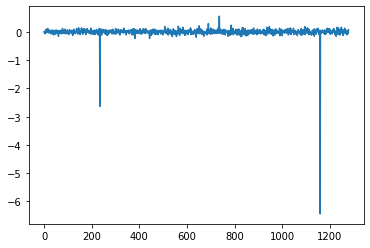

In [166]:
mutant.iloc[1,:].plot.line();

In [143]:
difference = (wt-mutant)*100

In [146]:
difference.sum(axis=1)

0       0.320376
1       0.481710
2       0.312745
3      -0.172836
4       0.414252
          ...   
6586    0.675470
6587    1.490860
6588   -4.357233
6589   -2.425898
6590   -2.844078
Length: 6591, dtype: float32

In [147]:
df_combine['difference'] = difference.sum(axis=1)

In [152]:
sub = df_combine.query('split == "test"')[['seq_id','difference']]

In [154]:
sub.reset_index(inplace=True,drop=True)

In [158]:
sub.rename(columns ={'difference':'tm'}, inplace=True)

In [160]:
sub.to_csv('submission.csv', index=False)

In [161]:
len(sub)

2413